# Le "quantile mapping" pour la précipitation - version saisonnière
Dans cette exemple, nous allons à nouveau appliquer des techniques de "quantile mapping à la précipitation".
Cette fois-ci, une version saisonnière par mois

In [12]:
import numpy as np
import pandas as pd
from pathlib import Path
from matplotlib import pyplot as plt

# Pour supprimer des avertissements
import warnings
warnings.filterwarnings('ignore')

### Il faut d'abord charger les données des projections et les données historiques
`data/historical_data.csv` et `data/historical_data.csv`

In [13]:
historical_data_file = Path(r'data/historical_data.csv')
projections_file = Path(r'data/projections.csv')

historical = pd.read_csv(historical_data_file, index_col=0, header = [0, 1])
projections = pd.read_csv(projections_file, index_col=0, header = [0, 1, 2, 3], skiprows=[4])

### Ciblons une projection en particulier
Le "Quantile Mappint" est appliqué à une projection à la fois.  
Nous avons besoin de:
- Définir le cas (rcp45 ou rcp85).
- Définir le modèle.
- Choisir le bassin versant.
- Une référence historique.
- La "projection" pour la période historique.
- La projection future.

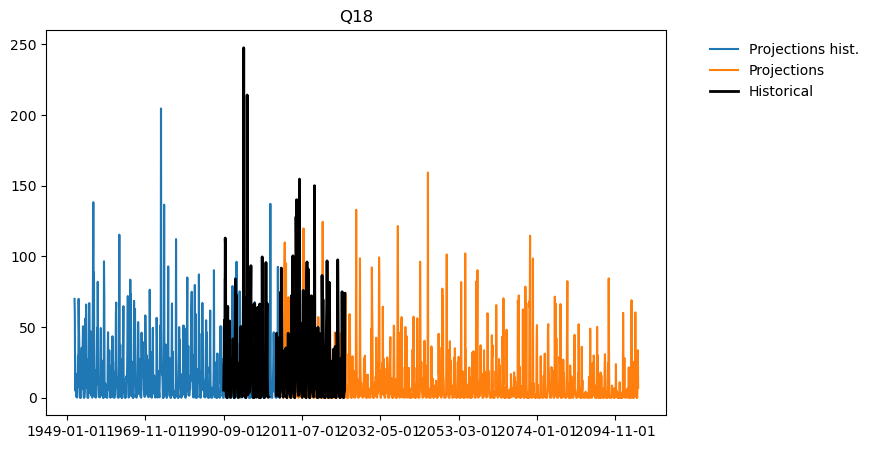

In [14]:
pr_historical = historical.loc[:, (slice(None), 'P [mm]')]
# Pour convertir la lettre à la fin du code en minuscule
pr_historical.columns = [c[0][0] + c[0][1:].lower() for c in pr_historical.columns]

cas = 'rcp85'
modele = 'CCCma-CanESM2_r1i1p1_SMHI-RCA4_v1'
bv = 'Q18'

pr_historical_bv = pr_historical.loc[:, bv]
pr_projection_historical_bv = projections.loc[:, ('pr', 'historical', bv, modele)]
pr_projection_bv = projections.loc[:, ('pr', cas, bv, modele)]

data = pd.concat({'Historical': pr_historical_bv, 'Projections hist.': pr_projection_historical_bv, 'Projections': pr_projection_bv}, axis=1).sort_index()
fig, ax = plt.subplots(figsize=(8, 5))
data.iloc[:, 1:].plot(ax=ax)
data.iloc[:, [0]].plot(ax=ax, linewidth=2, color='k')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)
_ = ax.set_title(bv)
plt.show()

### Appliquer le "Seasonal Quantile Mapping"
La saisonalité est definie par `windows`, `weight_function` et `group_mappers`.

In [19]:
from modules.multi_window_mapper import Multi_Window_Mapper
from modules.quantile_mapping import QuantileMapper, QuantileMapping

[[[1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12]]]


Variable,pr
Experiment,rcp85
Zone,Q18
Code,CCCma-CanESM2_r1i1p1_SMHI-RCA4_v1
1951-01-01,53.369362
1951-02-01,42.812124
1951-03-01,15.619056
1951-04-01,51.271852
1951-05-01,9.594567
...,...
2100-08-01,0.547390


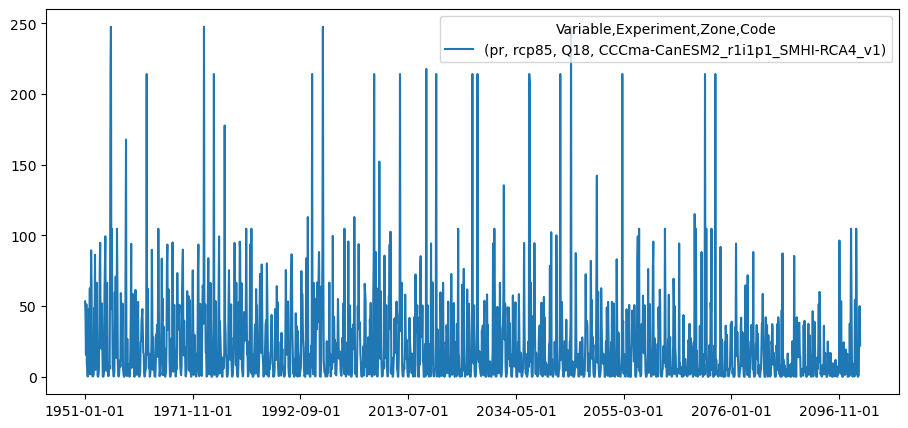

In [28]:
diagnostics_path = Path(r'temp/diagnostics_pr_' + cas + '_' + modele + '_' + bv + '_seasonal')

windows = [[[i] for i in range(1, 13)]]
print(windows)
           
kw_kernel = {
    'weight_function':lambda x: x,
    'windows': windows,
    'model': QuantileMapping,
    }
group_mappers = [lambda x: x.month]
qm = QuantileMapper(projection_historical=pr_projection_historical_bv, reference=pr_historical_bv,
                    kernel=Multi_Window_Mapper, kw_kernel=kw_kernel,
                    trend_window=5, # Le nombre d'années condidérées pour la moyenne glissante
                    hydrological_year_month_start=9,
                    group_mappers=group_mappers,
                    diagnostics_path=diagnostics_path)
qm.map()

# Joindre les projections historiques aux rcp pour couvrir toutes les dates
to_map = pd.concat((pr_projection_bv, pr_projection_historical_bv), axis=1).bfill(axis=1).iloc[:, 0]

corrected = qm.apply(to_map).dropna()
corrected = corrected.to_frame()
corrected.columns = pd.MultiIndex.from_product([['pr'], [cas], [bv], [modele]], names=['Variable', 'Experiment', 'Zone', 'Code'])

corrected.to_excel(diagnostics_path / 'corrected.xlsx')
corrected.to_csv(diagnostics_path / 'corrected.csv')

fig, ax = plt.subplots(figsize=(11, 5))
corrected.plot(ax=ax)

corrected

### Regarder les diagnostiques
Ils sont sur un dossier `temp/diagnostics_variable_cas_modele_bv_seasonal` que nous avons indiqué juste avant.

#### Commençons par les quantiles...

#### "Mois" 1

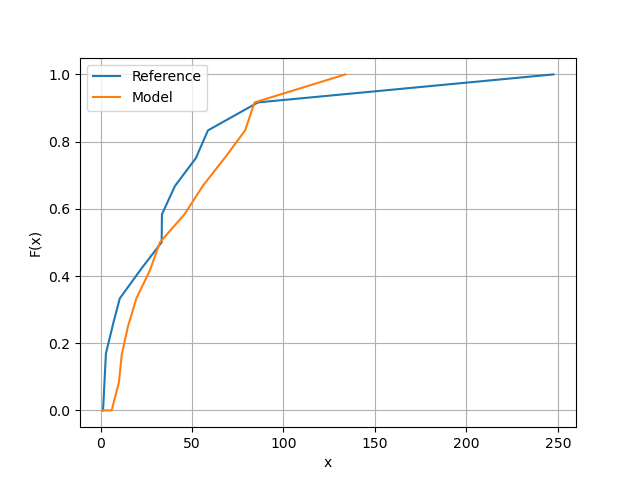

In [23]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(diagnostics_path / 'quantile_1.png')

#### "Mois" 6

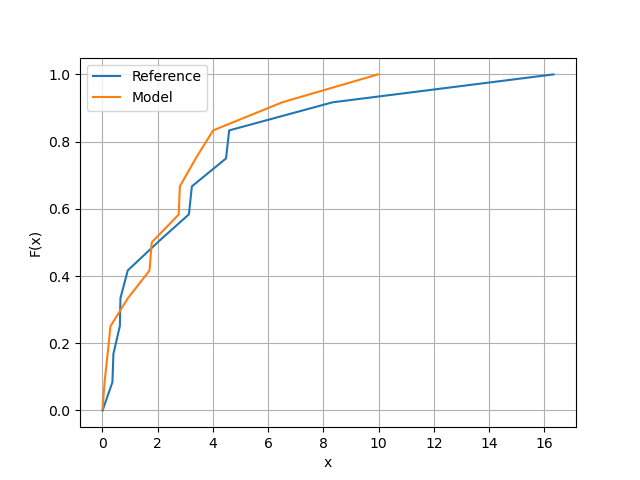

In [24]:
Image(diagnostics_path / 'quantile_6.png')

#### Les tendences
C'est important que la référence (les données historiques) colle avec le "mapped" (projection corrigée)

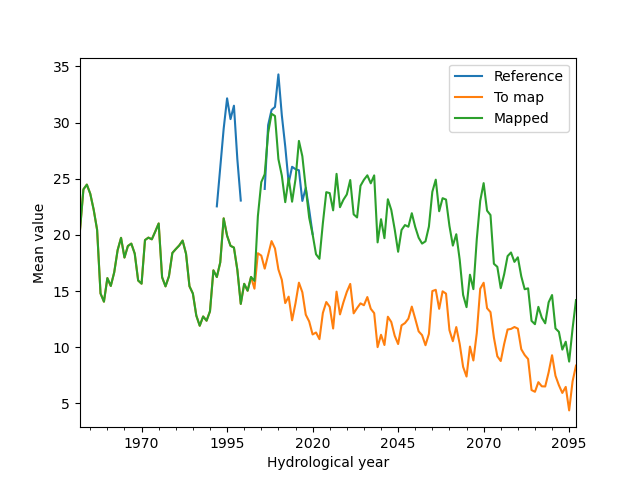

In [25]:
Image(diagnostics_path / 'trend.png')

#### Les tendences en termes de variabilité
Maintenant, nous regardons la moyenne mobile de l'écart-type.
C'est aussi important que la référence (les données historiques) colle avec le "mapped" (projection corrigée)

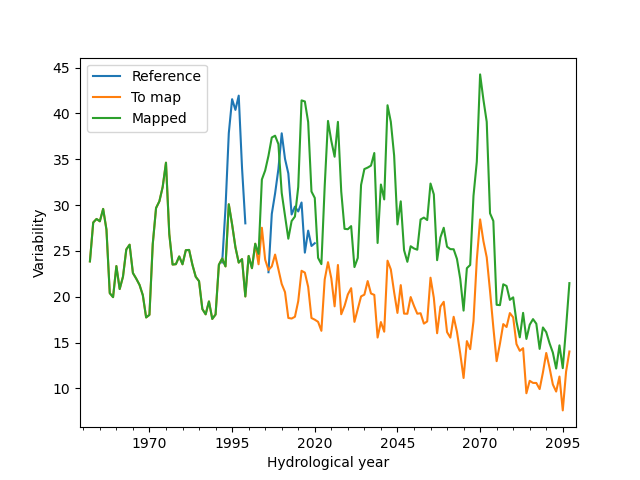

In [26]:
Image(diagnostics_path / 'trend std.png')

#### Finallement, la saisonalité
Ici, la référence et le "mapped" doivent être le plus proches possible, y compris leur intervale de confiance.

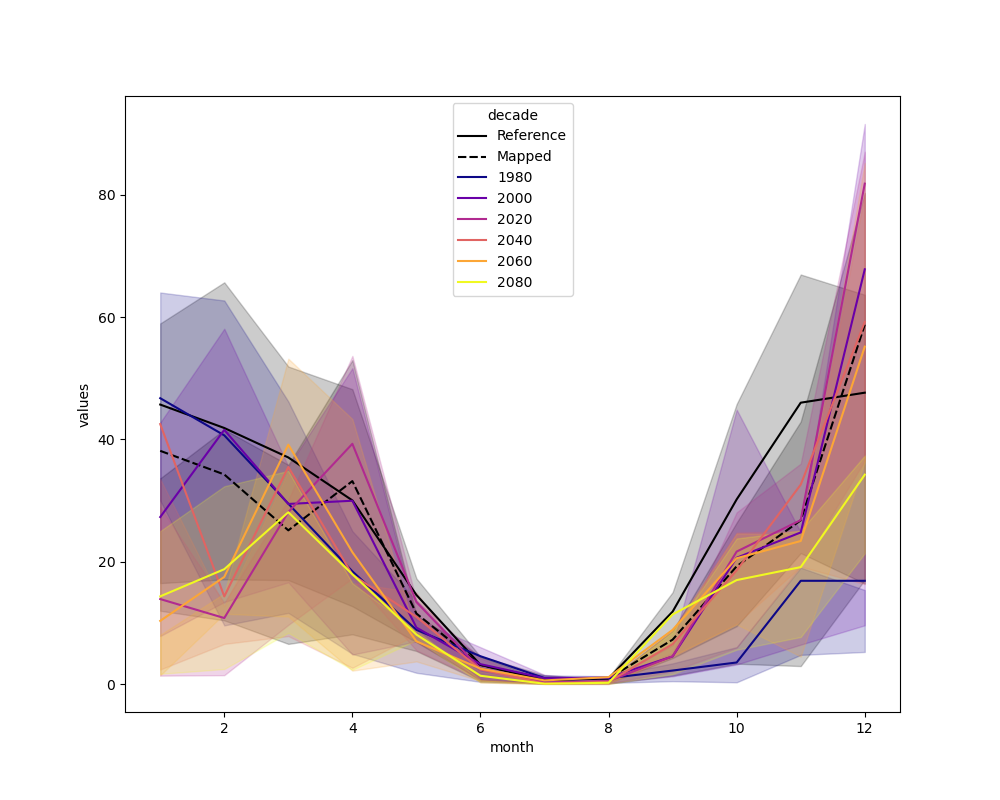

In [27]:
Image(diagnostics_path / 'yearly.png')